<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Hospi_change_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-0514059c7758>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces


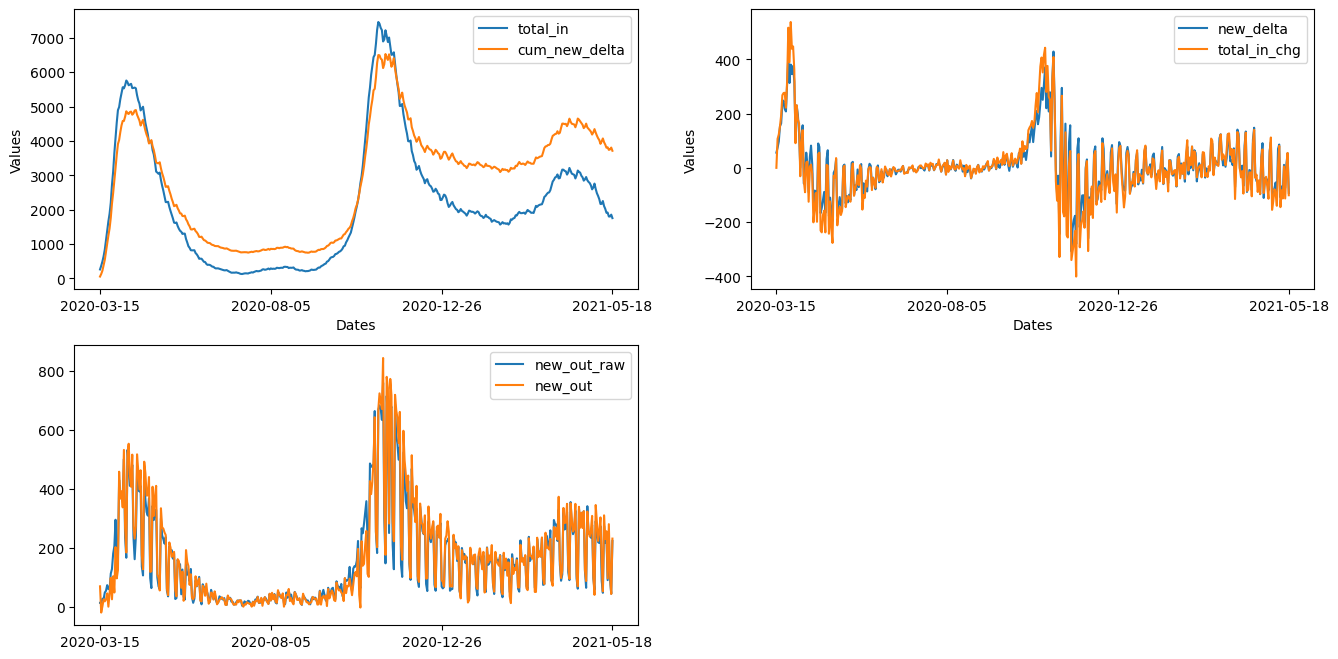

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy import optimize
#import datetime
#import time
#*******************************************************************************************************
#********* We decide to work with Hospi data in order to show the evolution of beta and identify the change point
#**************Meeting between Niko, PA and me on 12/12/2022
#Horpitalizations data in Belgium
import copy
from datetime import datetime   # useful for date ranges in plots
sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris, or sw_districts = 'London').  # PATODO fix London and stuff.
# ***********************************************************************************
# Load data Belgium
# *******   
# The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
# This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
# The link can be reached from https://epistat.wiv-isp.be/covid/
# Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf
data_url='/COVID19BE_HOSP_2021-05-16.csv'
data_raw = pd.read_csv(data_url)  # !! changed:21PA
#fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

if sw_districts == 'each':
    data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])

    # ***********************************************************************************
    # Process data Belgium
    # *******
    if sw_districts == 'sum':
        data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
    elif sw_districts == 'each':
        data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
    else:   
        data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

    data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns
        
    # Extract relevant data and recompute new_out:
    # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
    data_length = np.size(data,0)
    data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd--last columns (recall that Python uses 0-based indexing) and turn it into a numpy array of floats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

    #dates = data['DATE'])
    dates_raw = copy.deepcopy(data['DATE'])
    dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
    Dates = [None] * data_length
    for i in range(0,data_length):
        Dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

    col_total_in = 1
    col_new_in = 5
    col_new_out = 6
    total_in = data_num[:,col_total_in]
    new_in = data_num[:,col_new_in]
    new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
    new_delta = new_in - new_out_raw
    cum_new_delta = np.cumsum(new_delta)
    total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
    # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
    # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
    # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
    new_out = new_in - total_in_chg   # fixed new_out
    data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

    # Show Belgian data in figures:
    nb_xticks = 4
    dates_ticks = [None] * nb_xticks
    dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
    for i in range(0,nb_xticks):
        dates_ticks[i] = Dates[dates_ticks_ind[i]]

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.plot(Dates, total_in)
    plt.plot(Dates,cum_new_delta)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("total_in","cum_new_delta"))
    #plt.ylim([0,1000])

    plt.subplot(2,2,2)
    plt.plot(Dates,new_delta)
    plt.plot(Dates,total_in_chg)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("new_delta","total_in_chg"))

    plt.subplot(2,2,3)
    plt.plot(Dates,new_out_raw)
    plt.plot(Dates,new_out)
    plt.xticks(dates_ticks)
    plt.legend(("new_out_raw","new_out"))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


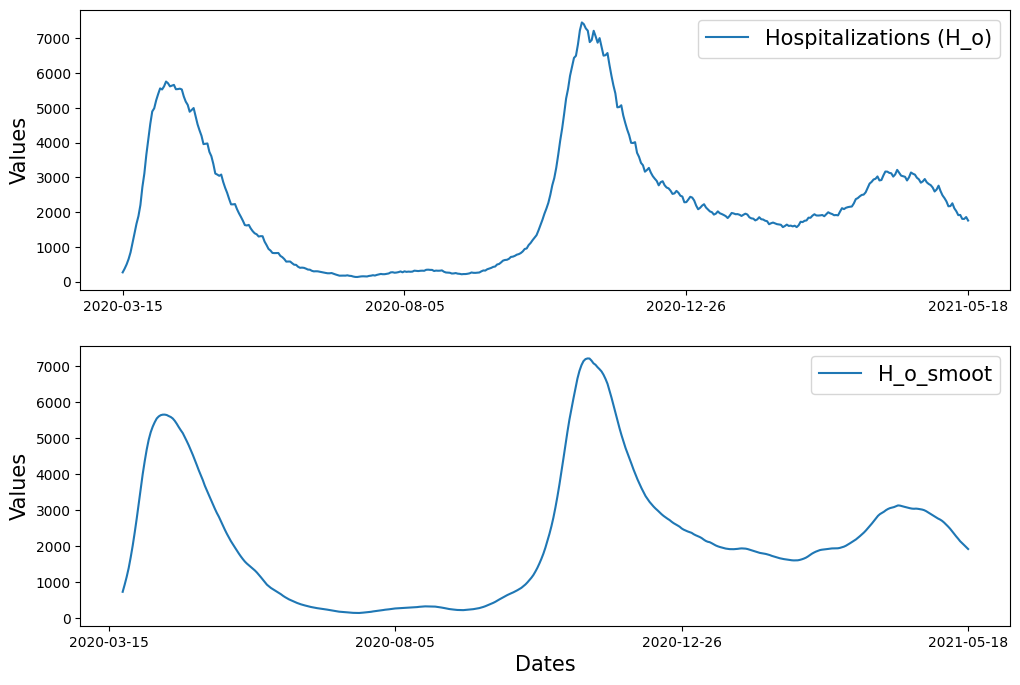

In [43]:
#Calculate and show the H_smooth with Moving Average method
N = 7  # The window length of moving average will be 2N+1.
H_smooth_MA = total_in * np.nan  # MA: moving average
for t in np.arange(0, len(total_in)):
    H_smooth_MA[t] = np.mean(total_in[t-N:t])

nb_xticks = 4
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = Dates[dates_ticks_ind[i]]

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(Dates, total_in, label="Hospitalizations (H_o)")
plt.xticks(dates_ticks)
#plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(fontsize=15)
plt.subplot(2,1,2)
plt.plot(Dates, H_smooth_MA, label="H_o_smoot")
plt.xticks(dates_ticks)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [44]:
# let's define the function form
def simu(H_init, beta_effective, tspan):
    simu_t_start = tspan[0]
    simu_t_end = tspan[1]
    H_smooth = np.full(simu_t_end, np.nan)  # set storage
    #Note: beta_effective = beta-gamma
    for t in np.arange(simu_t_start,simu_t_end):
       H_smooth[t] = H_init* np.exp(beta_effective*t)
    return H_smooth

def phi_exp(x, tspan_train, data_train):   # x := [H_init,beta_effective]
    H_init = x[0]
    beta_effective = x[1]
    H_smooth= simu(H_init,  beta_effective, tspan_train)  
    cost = (np.linalg.norm(H_smooth[train_t_start:train_t_end]-data_train[train_t_start:train_t_end]))**2
    return cost

#Test simu
H_smooth_MA_used = H_smooth_MA[7:]
data_train_simu = H_smooth_MA_used[:11]
H_init_simu = H_smooth_MA_used[0]
train_t_start_simu = 0
train_t_end_simu = 10
tspan_simu = [train_t_start_simu,train_t_end_simu]
beta_effective_simu = np.log(data_train_simu[train_t_end_simu]/data_train_simu[train_t_start_simu])/(train_t_end_simu)
print(np.c_[data_train_simu[:10], simu(H_init_simu, beta_effective_simu, tspan_simu)])

[[ 729.14285714  729.14285714]
 [ 928.85714286  864.41411325]
 [1145.         1024.78101769]
 [1389.42857143 1214.89933831]
 [1685.85714286 1440.28858532]
 [2010.28571429 1707.49225355]
 [2373.28571429 2024.26779302]
 [2759.57142857 2399.81182307]
 [3170.28571429 2845.02712833]
 [3600.85714286 3372.83918811]]


Optimization terminated successfully.
         Current function value: 60095.269647
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 93965.640426
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 158430.563515
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 240135.667388
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 328854.093724
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 426705.434520
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 502773.376814
         Iterations: 55
         Function evaluations: 1

<ipython-input-45-72704ac96d5b>:16: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  x_opt_exp = optimize.fmin(fun_exp,x_guess_exp)  # call the optimization solver


Optimization terminated successfully.
         Current function value: 67.340558
         Iterations: 184
         Function evaluations: 362
Optimization terminated successfully.
         Current function value: 46.612321
         Iterations: 203
         Function evaluations: 377
Optimization terminated successfully.
         Current function value: 33.703082
         Iterations: 192
         Function evaluations: 363
Optimization terminated successfully.
         Current function value: 34.079134
         Iterations: 194
         Function evaluations: 358
Optimization terminated successfully.
         Current function value: 39.086923
         Iterations: 185
         Function evaluations: 349
Optimization terminated successfully.
         Current function value: 49.942899
         Iterations: 164
         Function evaluations: 313
Optimization terminated successfully.
         Current function value: 60.637914
         Iterations: 180
         Function evaluations: 336
Optimization 

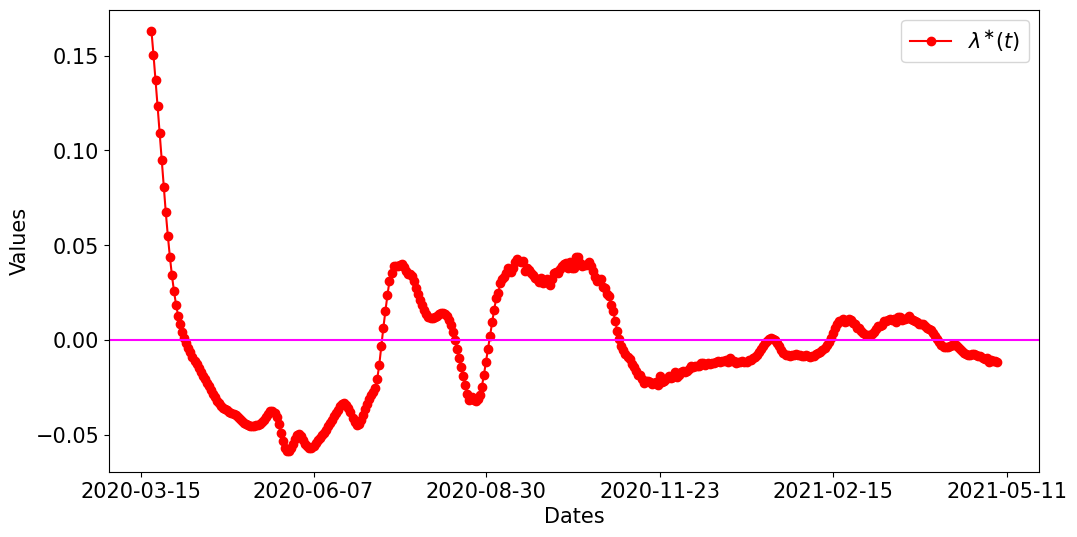

In [45]:
#Define a window of 10 days and the H_init is taken in the beginning on each window.
H_smooth_MA_used = H_smooth_MA[7:]
H = H_smooth_MA_used*np.nan
d=5
beta_effective_opt_exp = H_smooth_MA_used*np.nan
H_init_opt_exp = H_smooth_MA_used*np.nan
for t in np.arange(d, len(H_smooth_MA_used)-d):
    train_t_start = t-d
    train_t_end = t+d
    tspan_train = [train_t_start,train_t_end]
    data_train = H_smooth_MA_used
    H_init = data_train[train_t_start]
    beta_effective_guess = np.log(data_train[train_t_end]/data_train[train_t_start])/(train_t_end)
    fun_exp = lambda x:phi_exp(x,tspan_train,data_train)
    x_guess_exp = [H_init, beta_effective_guess]
    x_opt_exp = optimize.fmin(fun_exp,x_guess_exp)  # call the optimization solver
    H_init_opt_exp[t] = x_opt_exp[0]
    beta_effective_opt_exp[t] = x_opt_exp[1]
    H[t] = H_init_opt_exp[t]*np.exp(beta_effective_opt_exp[t]*t) 
    
nb_xticks = 6
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(H_smooth_MA_used)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = Dates[dates_ticks_ind[i]]
plt.figure(figsize=(12,6))
#plt.subplot(211)
plt.plot(Dates[d:len(H_smooth_MA_used)-d], beta_effective_opt_exp[d:len(H_smooth_MA_used)-d],'o-', color='red')
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$'], fontsize=15)
plt.show()

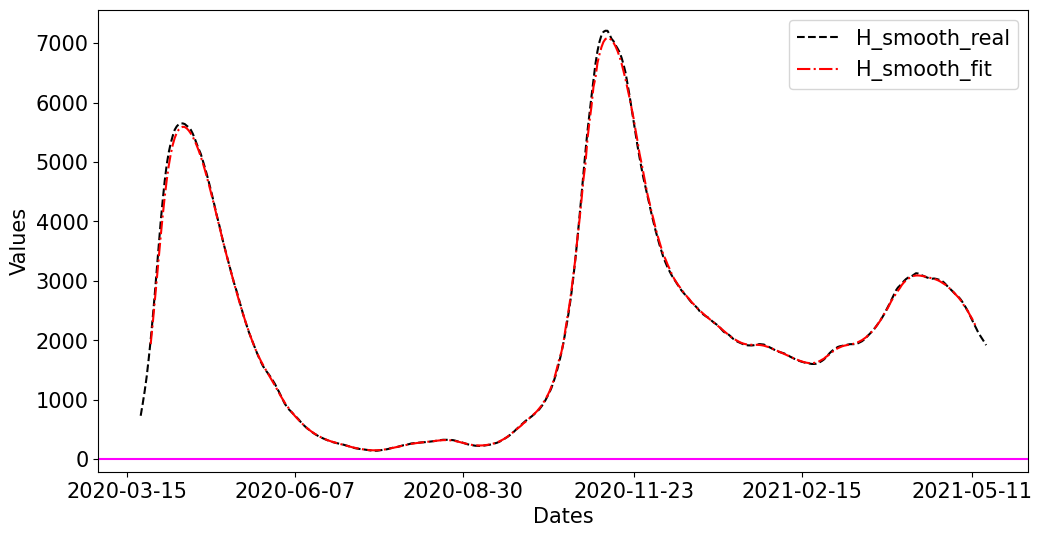

In [58]:
plt.figure(figsize=(12,6))
#plt.subplot(212)
plt.plot(Dates[7:], H_smooth_MA_used,'--',  color='black') 
plt.plot(Dates[7+d:len(H_smooth_MA)-d], H[d:len(H_smooth_MA_used)-d],'-.', color='red')  
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['H_smooth_real', 'H_smooth_fit'], fontsize=15)
plt.show()

In [60]:
RMSE_train = np.linalg.norm(H[d:len(H_smooth_MA_used)-d] - H_smooth_MA_used[d:len(H_smooth_MA_used)-d]) / np.sqrt(len(H_smooth_MA_used)-d-d)
MAE_train = np.mean(np.abs(H[d:len(H_smooth_MA_used)-d] - H_smooth_MA_used[d:len(H_smooth_MA_used)-d]))
MASE_train = MAE_train / np.mean(np.abs(H_smooth_MA_used[(d+1):len(H_smooth_MA_used)-d] - H_smooth_MA_used[d:(len(H_smooth_MA_used)-d-1)]))
stats_all = np.full(2, np.nan)
stats_all = [RMSE_train, MASE_train] 
print("******************** FORECAST ACCURACY MEASURES - latex table ********************")
print('\\begin{tabular}{|c|c|}')
print('\\hline')
print('RMSE\_train  & MASE\_train  \\\\ \\hline')
print(stats_all[0].round(2), "&", stats_all[1].round(2), "\\\hline")

******************** FORECAST ACCURACY MEASURES - latex table ********************
\begin{tabular}{|c|c|}
\hline
RMSE\_train  & MASE\_train  \\ \hline
51.74 & 0.42 \\hline


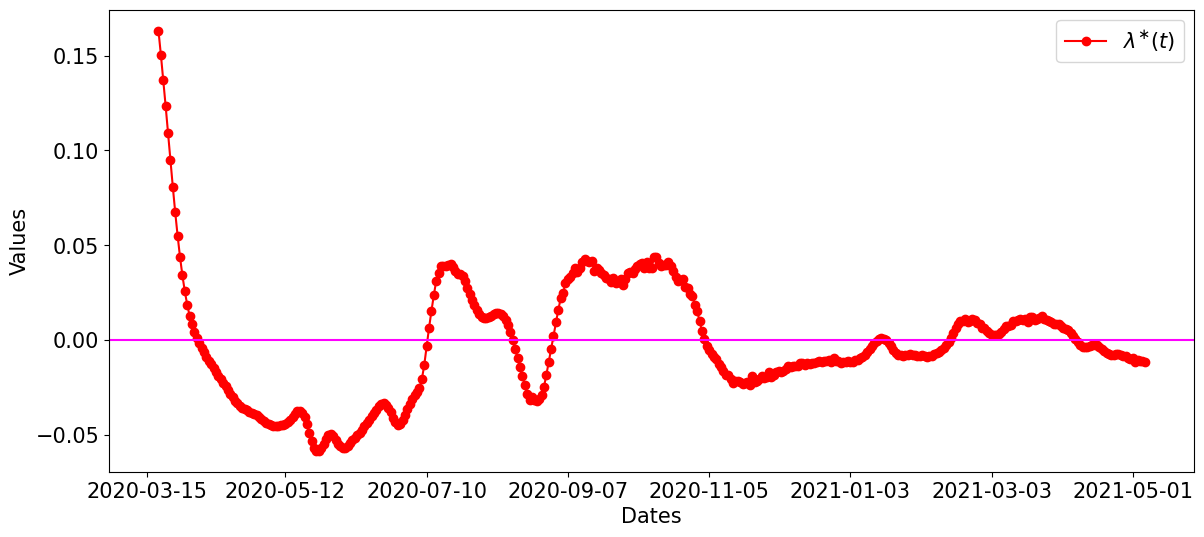

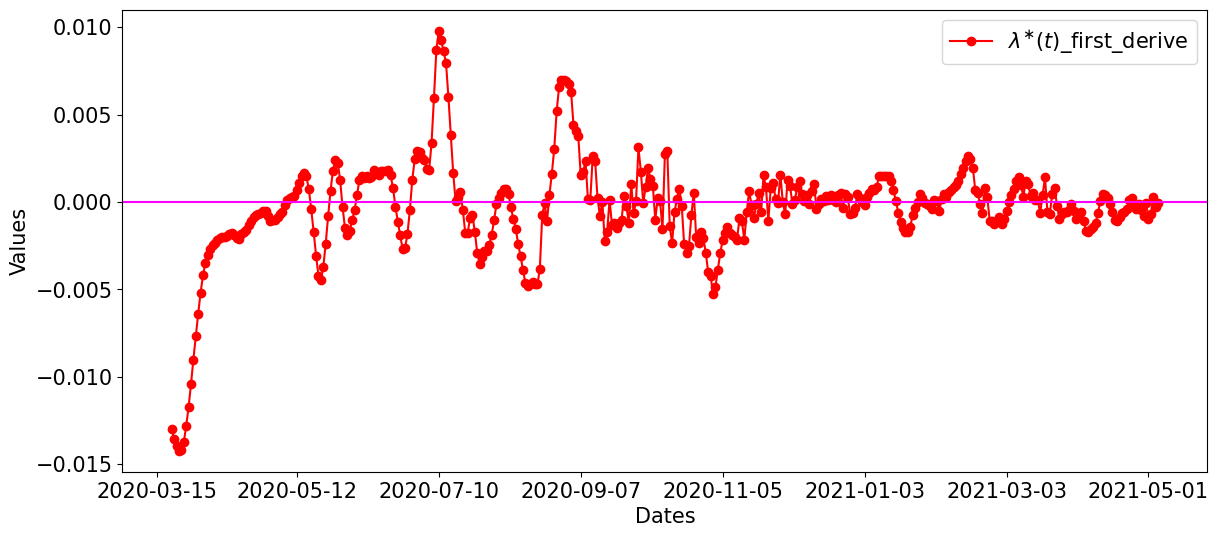

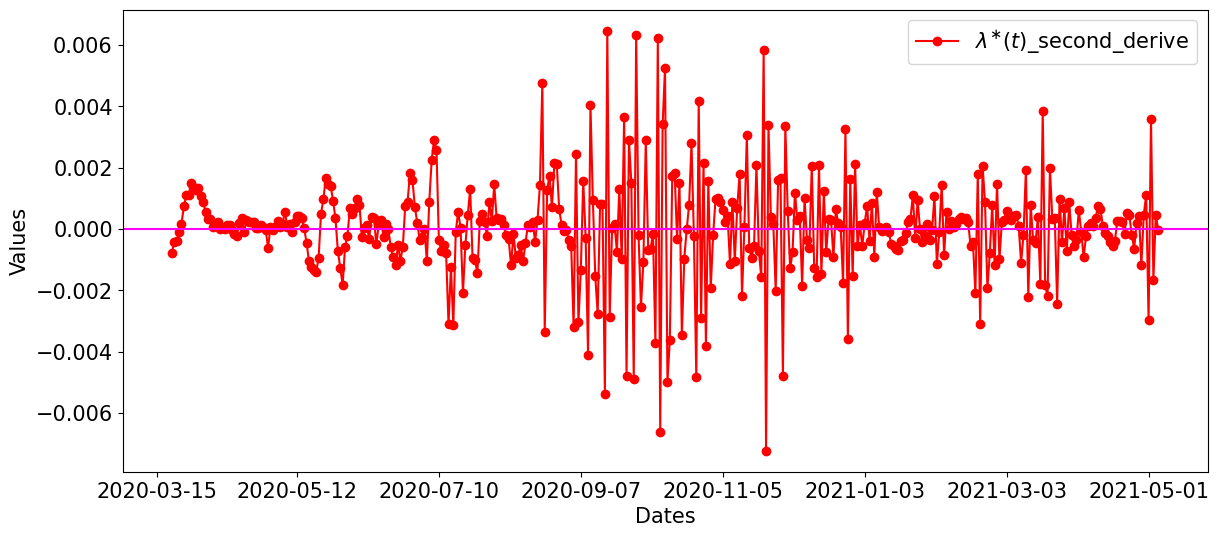

In [67]:
#************** master variable
Lambda = beta_effective_opt_exp[d:len(H_smooth_MA_used)-d]
first_derive_Lambda = Lambda*np.nan
for t in np.arange(1, len(Lambda)-1):
    delta_t=1
    first_derive_Lambda[t]= (Lambda[t+1]-Lambda[t-1])/2*delta_t
Lambda_prime = first_derive_Lambda[1:len(Lambda)-1]

second_derive_Lambda = Lambda*np.nan
for t in np.arange(1, len(Lambda)-1):
    delta_t=1
    second_derive_Lambda[t]= (Lambda[t+1]-2*Lambda[t] + Lambda[t-1])/delta_t**2
Lambda_prime_prime = second_derive_Lambda[1:len(Lambda)-1]

nb_xticks = 8
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(Lambda)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = Dates[dates_ticks_ind[i]]

plt.figure(figsize=(14,6))
#plt.subplot(311)
plt.plot(Dates[d:len(H_smooth_MA_used)-d], beta_effective_opt_exp[d:len(H_smooth_MA_used)-d],'o-', color='red')
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$'], fontsize=15)

plt.figure(figsize=(14,6))
#plt.subplot(312)
plt.plot(Dates[d+1:len(H_smooth_MA_used)-d-1], Lambda_prime,'o-', color='red')
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$_first_derive'], fontsize=15)

plt.figure(figsize=(14,6))
#plt.subplot(313)
plt.plot(Dates[d+1:len(H_smooth_MA_used)-d-1], Lambda_prime_prime,'o-', color='red')
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$_second_derive'], fontsize=15)
plt.show()

S_diff:  3.434987830557377 S_max:  2.430324239268458 S_min:  -1.0046635912889188
maximum reached at:  2020-07-05 00:00:00 minimum reached at:  2020-04-01 00:00:00


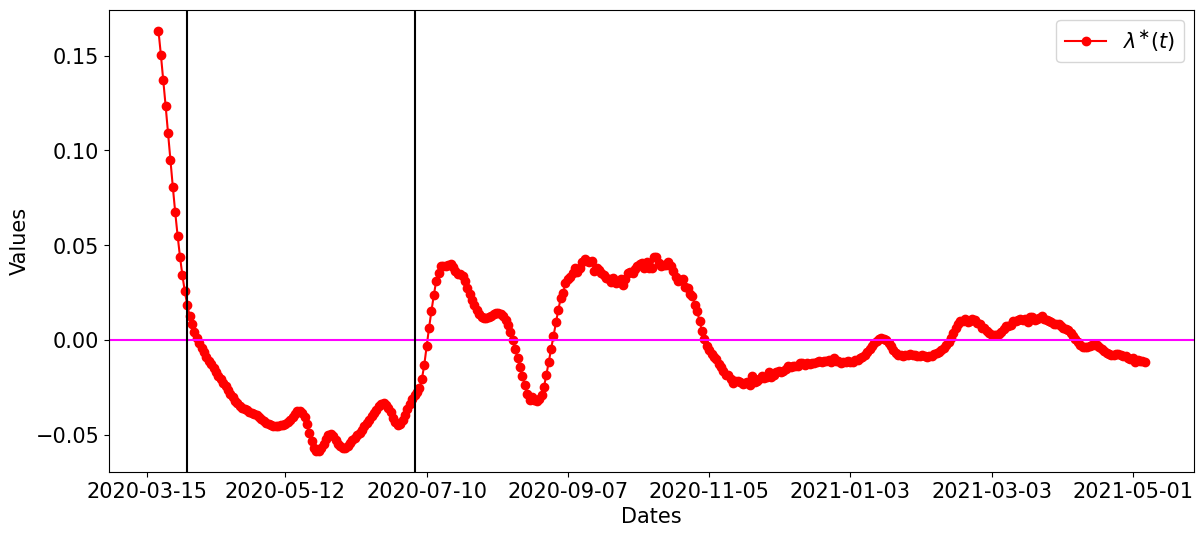

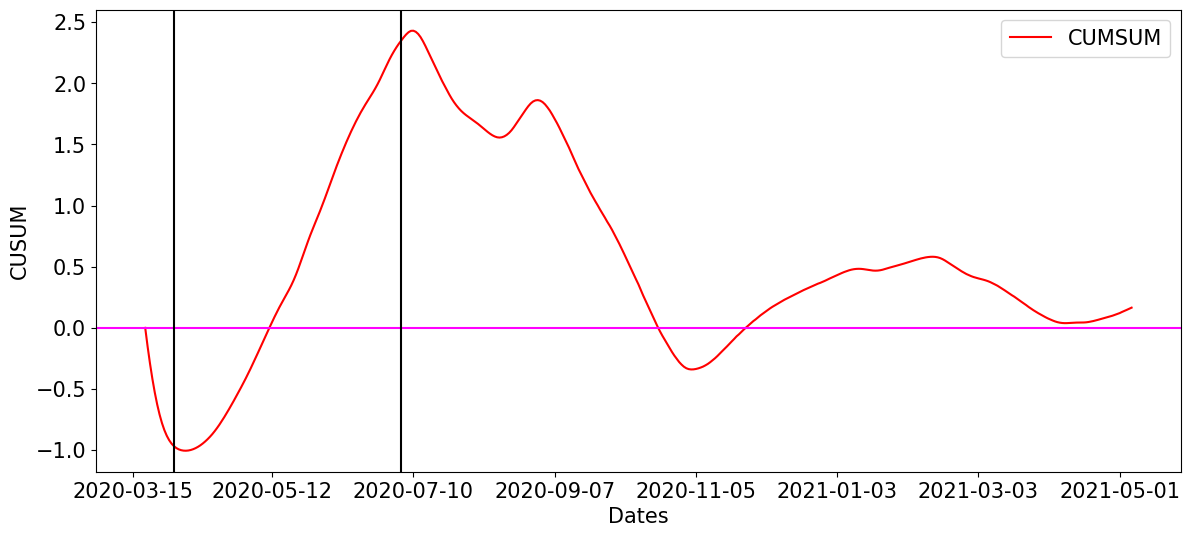

In [68]:
#***************** Cummulative sum (CUSUM) method****************
Lambda_bar = np.mean(Lambda) #First calculate the average
S = Lambda*np.nan
for i in np.arange(0, len(Lambda)):
  if i ==0:
      S[0] = 0 #Start the cumulative sum at zero by setting
  else:
      S[i] = S[i-1] - (Lambda[i] - Lambda_bar) #Calculate the other cumulative sums by adding the difference between current value and the average to the previous sum,
S_diff = np.max(S) - np.min(S)
print("S_diff: ", S_diff, "S_max: ",np.max(S), "S_min: ",np.min(S))
max, min = np.argmax(S), np.argmin(S)
print("maximum reached at: ", Dates[max],"minimum reached at: ", Dates[min])

plt.figure(figsize=(14,6))
#plt.subplot(311)
plt.plot(Dates[d:len(H_smooth_MA_used)-d], beta_effective_opt_exp[d:len(H_smooth_MA_used)-d],'o-', color='red')
plt.axhline(y=0, color="magenta")
plt.axvline(x=Dates[max] , color="black")
plt.axvline(x=Dates[min] , color="black")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$'], fontsize=15)
plt.show()
#****************************************************************************************************
plt.figure(figsize=(14,6))
plt.plot(Dates[d:len(H_smooth_MA_used)-d], S, color='red')
plt.axhline(y=0, color="magenta")
plt.axvline(x=Dates[max] , color="black")
plt.axvline(x=Dates[min] , color="black")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("CUSUM", fontsize=15)
plt.legend(['CUMSUM'], fontsize=15)
plt.show()

S_diff:  24.850573657912243 S_max:  13.865882081126035 S_min:  -10.98469157678621
maximum reached at:  2020-12-19 00:00:00 minimum reached at:  2020-04-19 00:00:00
S_diff:  25.153685737220414 S_max:  3.9905348923668797 S_min:  -21.163150844853533
maximum reached at:  2020-03-31 00:00:00 minimum reached at:  2021-01-10 00:00:00
S_diff:  21.662435887039962 S_max:  5.376952946783067 S_min:  -16.285482940256895
maximum reached at:  2021-02-15 00:00:00 minimum reached at:  2020-04-24 00:00:00
S_diff:  12.126504030887741 S_max:  3.710060473042676 S_min:  -8.416443557845065
maximum reached at:  2020-04-06 00:00:00 minimum reached at:  2020-08-10 00:00:00
S_diff:  24.426042189490374 S_max:  9.983388476335012 S_min:  -14.442653713155362
maximum reached at:  2020-09-11 00:00:00 minimum reached at:  2021-04-05 00:00:00


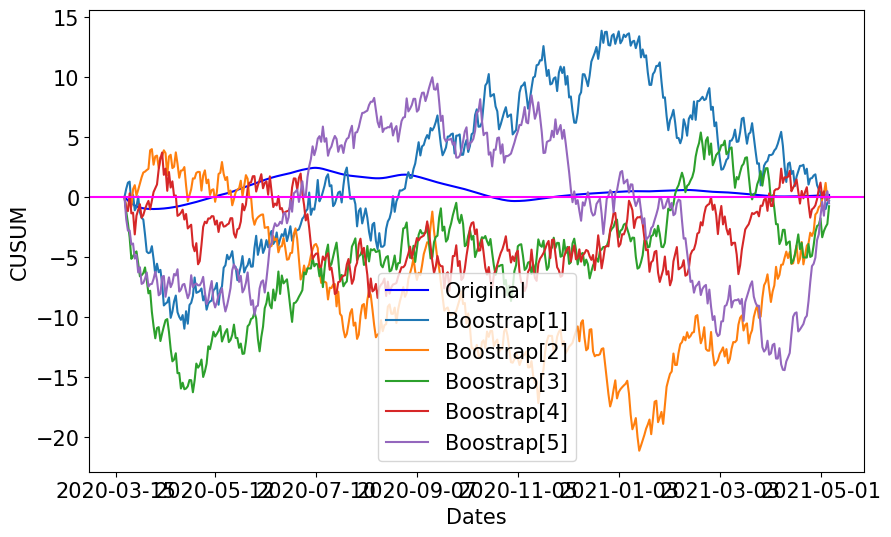

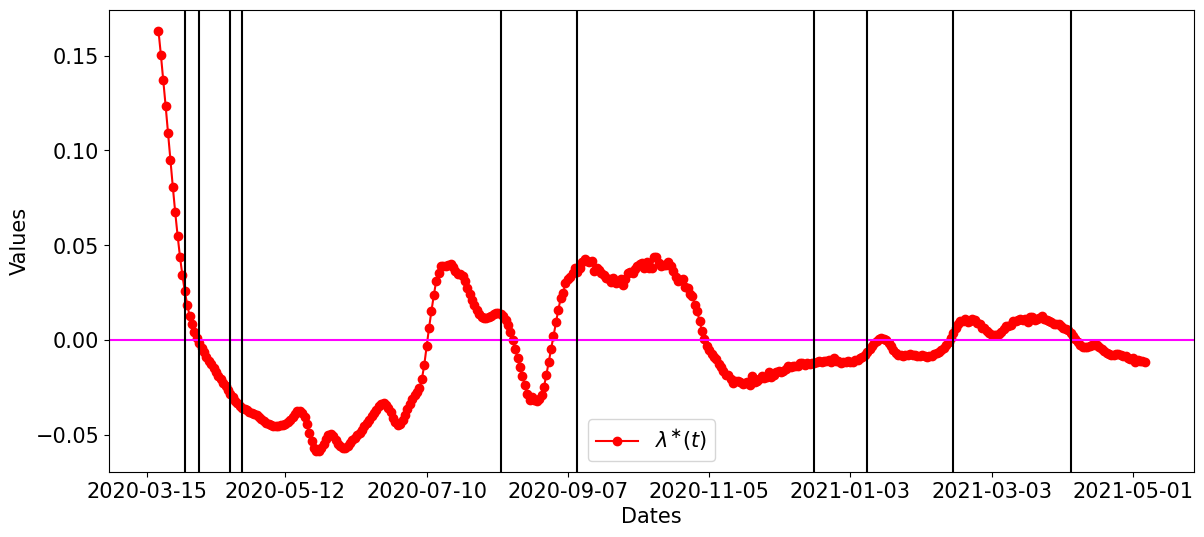

In [70]:
#**estimator of the magnitude of the change has been selected, the bootstrap analysis can be performed
import random
max_boost, min_boost = np.zeros(6)*np.nan, np.zeros(6)*np.nan
plt.figure(figsize=(10,6))
plt.plot(Dates[d:len(H_smooth_MA_used)-d], S, color='blue', label="Original")
for j in np.arange(1,6):
  random.shuffle(S) #Generate a bootstrap sample of S randomly named bootstrap variable
  #calculate the bootstrap CUSUM
  S_boost = Lambda*np.nan
  for i in np.arange(0, len(S)):
    if i ==0:
        S_boost[0] = 0 #Start the cumulative sum at zero by setting
    else:
        S_boost[i] = S_boost[i-1] - (S[i] - np.mean(S)) #Calculate the other cumulative sums by adding the difference between current value and the average to the previous sum,
  S_boost_diff = np.max(S_boost) - np.min(S_boost)
  print("S_diff: ", S_boost_diff, "S_max: ",np.max(S_boost), "S_min: ",np.min(S_boost))
  max_boost[j], min_boost[j] = np.argmax(S_boost), np.argmin(S_boost)
  print("maximum reached at: ", Dates[int(max_boost[j])],"minimum reached at: ", Dates[int(min_boost[j])])

  plt.plot(Dates[d:len(H_smooth_MA_used)-d], S_boost, label="Boostrap["+str(j)+"]")
  #plt.axvline(x=Dates[int(max_boost[j])] , color="black")
  #plt.axvline(x=Dates[int(min_boost[j])] , color="black")
plt.axhline(y=0, color="magenta")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("CUSUM", fontsize=15)
plt.legend(fontsize=15)
plt.show()
#**************************************************************************************
plt.figure(figsize=(14,6))
#plt.subplot(311)
plt.plot(Dates[d:len(H_smooth_MA_used)-d], beta_effective_opt_exp[d:len(H_smooth_MA_used)-d],'o-', color='red')
plt.axhline(y=0, color="magenta")
for p in np.arange(1, len(max_boost)):
    plt.axvline(x=Dates[int(max_boost[p])] , color="black")
    plt.axvline(x=Dates[int(min_boost[p])] , color="black")
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(['$\lambda^{\\ast} (t)$'], fontsize=15)
plt.show()

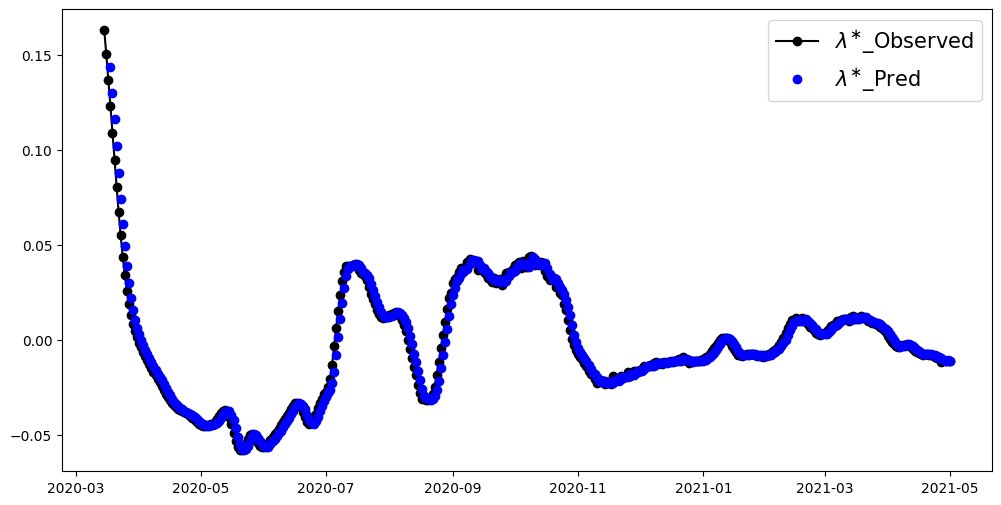

In [71]:
from scipy.optimize import least_squares
#************ We fit data in times t-1 and t-2 to predict the value at time t.
# let's define the function form
def modell(x, tspan, u):
    return x[2]*u[tspan[0]] + x[1]*u[tspan[1]] + x[0]      
def funn(x, tspan, u, y):
    return modell(x, tspan, u) - y
u = Lambda
plt.figure(figsize=(12,6))
plt.plot(Dates[:len(u)], u, 'o-', color='black')
for t in np.arange(3, len(u)):
    tspan = [t-2, t-1]
    y = u[tspan]
    x0 = [1, 1, 1]
    #print(modell(x0, tspan, u))
    #print(funn(x0, tspan, u, y))
    res = least_squares(funn,x0, args=(tspan, u, y))
    y_hat = modell(res.x, tspan, u)
    #print("real value: ", u[t], "predicted value: ", y_hat)
    plt.plot(Dates[t], y_hat, 'o', color='blue')
plt.legend(["$\lambda^{\\ast}$_Observed", "$\lambda^{\\ast}$_Pred"], fontsize=15)
plt.show()

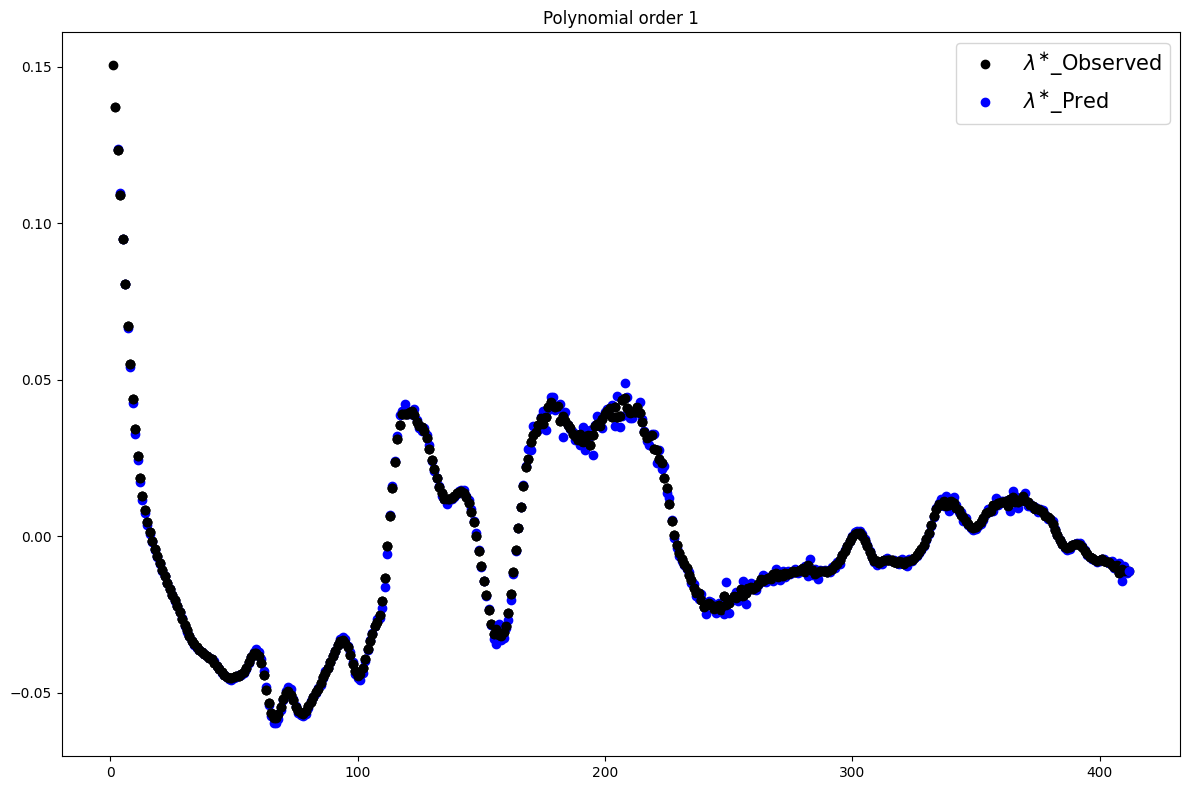

In [72]:
plt.figure(figsize = (12, 8))
#for t in np.arange(3, 7):
for t in np.arange(3,len(Lambda)):
    x_d = np.array([t-2, t-1])
    y_d = np.array([Lambda[t-2], Lambda[t-1]])
    # get the polynomial coefficients
    res = np.polyfit(x_d, y_d, 1)
    #print(res)
    y = res[0]*t + res[1]
    plt.plot(np.array([t-2,t-1,t]), np.array([Lambda[t-2], Lambda[t-1], Lambda[t]]), 'o', color='black')
    # evaluate the values for a polynomial
    values = np.polyval(res, x_d)
    #plt.plot(x_d, values)
    plt.plot(t, y, 'o', color='blue')
plt.legend(["$\lambda^{\\ast}$_Observed", "$\lambda^{\\ast}$_Pred"], fontsize=15)
plt.title(f'Polynomial order 1')
plt.tight_layout()
plt.show()

In [111]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
# split dataset
X = Lambda
coefs = []
RMSE_train = np.full(len(X)-2, np.nan)

for t in np.arange(6, len(X)-2):
    train = X[:t]
    model = AutoReg(train, lags=2)
    model_fit = model.fit()
    coef = model_fit.params
    coefs.append(coef)
    #print(model_fit.summary())
    #print(t, coef)
    y_1 = coef[0] + coef[1]*X[t-1] + coef[2]*X[t-2]
    y_2 = coef[0] + coef[1]*X[t] + coef[2]*X[t-1]
    y_3 = coef[0] + coef[1]*X[t+1] + coef[2]*X[t]
    #print("Position: ",t, "predic values: ",  [y_1, y_2, y_3] )
    #print("Position: ",t, "real values: ",  [X[t], X[t+1], X[t+2]] )
    RMSE_train[t] = np.linalg.norm(np.array([X[t], X[t+1], X[t+2]]) - np.array([y_1, y_2, y_3]) ) / np.sqrt(len([y_1, y_2, y_3] ))
    print("Position: ",t,'RMSE\_train: ',RMSE_train[t])

Position:  6 RMSE\_train:  0.001074466101916558
Position:  7 RMSE\_train:  0.0004608176999246307
Position:  8 RMSE\_train:  0.0008068068790677185
Position:  9 RMSE\_train:  0.0009781018226650768
Position:  10 RMSE\_train:  0.0005372238265017013
Position:  11 RMSE\_train:  0.0007160003027556931
Position:  12 RMSE\_train:  0.0005942634537695594
Position:  13 RMSE\_train:  0.0005095348366957784
Position:  14 RMSE\_train:  0.0006565911942947531
Position:  15 RMSE\_train:  0.0007145287153064194
Position:  16 RMSE\_train:  0.000704600045064774
Position:  17 RMSE\_train:  0.0006892600110085899
Position:  18 RMSE\_train:  0.0005990076908399079
Position:  19 RMSE\_train:  0.0005395766443591839
Position:  20 RMSE\_train:  0.00048092865820549476
Position:  21 RMSE\_train:  0.0004864490208301477
Position:  22 RMSE\_train:  0.0005463242313439605
Position:  23 RMSE\_train:  0.00048036329316741264
Position:  24 RMSE\_train:  0.00043192774803353916
Position:  25 RMSE\_train:  0.0004250772082907186
Pos